# Convolution modes

In [5]:
import numpy as np
import scipy.signal

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler
import matplotlib.path as path
import matplotlib.patches as patches
from matplotlib.transforms import Bbox
import warnings
warnings.simplefilter('ignore')

from matplotlib.animation import FuncAnimation
import matplotlib.style
matplotlib.style.use('bauhaus')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
from myst_nb import glue


np.random.seed(20200101)

colors = [_['color'] for _ in list(matplotlib.rcParams['axes.prop_cycle'])]

def figaspect(arg):
    # min/max sizes to respect when autoscaling.  If John likes the idea, they
    # could become rc parameters, for now they're hardwired.
    figsize_min = np.array((4.0, 2.0))  # min length for width/height
    figsize_max = np.array((16.0, 16.0))  # max length for width/height

    # Extract the aspect ratio of the array
    isarray = hasattr(arg, 'shape') and not np.isscalar(arg)
    if isarray:
        nr, nc = arg.shape[:2]
        arr_ratio = nr / nc
    else:
        arr_ratio = arg

    # Height of user figure defaults
    fig_width = matplotlib.rcParams['figure.figsize'][0]

    # New size for the figure, keeping the aspect ratio of the caller
    newsize = np.array((fig_width, fig_width *arr_ratio))
    #newsize = np.array((fig_height / arr_ratio, fig_height))

    # Sanity checks, don't drop either dimension below figsize_min
    newsize /= min(1.0, *(newsize / figsize_min))

    # Avoid humongous windows as well
    newsize /= max(1.0, *(newsize / figsize_max))

    # Finally, if we have a really funky aspect ratio, break it but respect
    # the min/max dimensions (we don't want figures 10 feet tall!)
    newsize = np.clip(newsize, figsize_min, figsize_max)
    return newsize

As we saw in the first section of this chapter, the first few samples produced by a convolution $y = x*h$ depend on *negative sample indices* $x[n-k]$ where $n < k$.
To ensure that the convolution is well-defined for these indices, we assume $x[n-k]=0$ for $n<k < K$ (the length of the filter), which we may also think of as **padding** the signal with zeros on the left.
This means that we can think of the first $k$ samples of $y$ as depending on these additional zeros.  Any sample $n \geq k$ will not depend on this padding.

Depending on how you want to use convolution, it may or may not be appropriate to include these first few samples.
In this section, we'll describe different commonly used **modes** of convolution, which can all be implemented by some combination of padding and trimming the inputs and outputs.
Note that these modes do not fundamentally alter how convolution works: all that changes is which outputs are retained in the output signal.

Throughout this section, we will assume that $x$ and $h$ have $N$ and $K$ samples, respectively, and that $N \geq K$.
This latter assumption is for convenience, and as we'll see in the next section, it is not necessary.

## Full mode

**Full mode** convolution is implemented by padding the input on both the left *and the right* by $K-1$ samples each.
A full mode convolution will have $N + K - 1$ output samples.

The intuition for this is that it captures both a *warm up* phase ($n < K$), as well as a *ringing out* phase ($N \leq n < N + K$).
The warm up phase contains all outputs which depend on some (but not only) prepended silence, the ringing out phase similarly contains outputs which depend on some (but not only) appended silence.

These effects can be seen in the example below, where we compute a full convolution between an increasing sequence $[5, 6, 7, 8, 9]$ and a differencing filter $[1, 0, -1]$.
With this example, we'll have $y[n] = x[n] - x[n-2]$ in general, which will be the constant 2 for this sequence.
However, at the beginning and end, you can see the effects of left- and right-padding by zeros.

In [6]:
# Full mode example
x = np.arange(5, 10)

# This is a differencing filter:
#   y[n] = x[n] - x[n-2]
h = np.array([1, 0, -1])

y = np.convolve(x, h, mode='full')

print('Input:\t\t', x)
print('Filter:\t\t', h)
print('Full convolution:\t', y)

Input:		 [5 6 7 8 9]
Filter:		 [ 1  0 -1]
Full convolution:	 [ 5  6  2  2  2 -8 -9]


## Valid mode

**Valid mode** convolution eliminates any outputs that depend on padding at all.
If we start from the **full mode** convolution described above, the *valid* outputs are the middle 3, because they depend only on values explicitly observed in the input: $7-5$, $8-6$, and $9-7$.

A valid mode convolution will have $N - K + 1$ output samples.

In [7]:
y = np.convolve(x, h, mode='valid')
print('Input:\t\t', x)
print('Filter:\t\t', h)
print('Valid convolution:\t', y)

Input:		 [5 6 7 8 9]
Filter:		 [ 1  0 -1]
Valid convolution:	 [2 2 2]


## Same mode

**Same mode** is derived from **full mode** by extracting $N$ samples from the full convolution, so that 
the output $y$ has the *same length* $N$ as $x$.
Most implementations of **same mode** extract the *middle* of the output, so that both the first and last $K/2$ samples depend on zero padding, as demonstrated below:

In [8]:
y = np.convolve(x, h, mode='same')

print('Input:\t\t', x)
print('Filter:\t\t', h)
print('Same convolution:\t', y)

Input:		 [5 6 7 8 9]
Filter:		 [ 1  0 -1]
Same convolution:	 [ 6  2  2  2 -8]


Sometimes, you may want a left-aligned (or right-aligned) same-mode convolution, including the warm-up but not ring-out (or vice versa).
These can be helpful if you want to introduce a delay effect to a signal, but retain its length.
While the standard implementation used above does not do this, it's easy enough to construct by trimming the full mode convolution differently:

In [9]:
# Include only the warm-up phase
N = len(x)
y = np.convolve(x, h, mode='full')
y = y[:N]  # Truncate to the first N samples

print('Input:\t\t', x)
print('Filter:\t\t', h)
print('Same (left-align):\t', y)

Input:		 [5 6 7 8 9]
Filter:		 [ 1  0 -1]
Same (left-align):	 [5 6 2 2 2]


In [10]:
# Discard the warm-up, but include the ring-out
N = len(x)
y = np.convolve(x, h, mode='full')
y = y[-N:]  # Truncate to the last N samples

print('Input:\t\t', x)
print('Filter:\t\t', h)
print('Same (right-align):\t', y)

Input:		 [5 6 7 8 9]
Filter:		 [ 1  0 -1]
Same (right-align):	 [ 2  2  2 -8 -9]


## Summary
The different convolution modes are summarized visually below, with $h$ as the differencing filter used above, and $x$ now as a square wave over 25 samples.

The shaded regions of the bottom subplot correspond to those which depend on zero-padding.

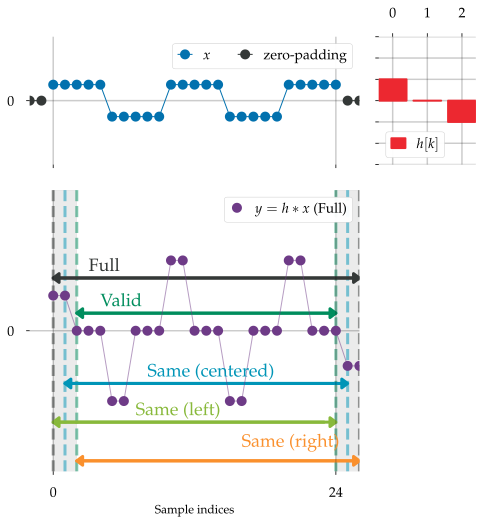

In [11]:
## TODO: animate this
# Make an array of samples with a square wave
from matplotlib import gridspec
fs = 50
k = 3
n = np.arange(fs//2)
N = len(n)
times = np.arange(fs) / fs
x = scipy.signal.square(2 * np.pi * 5 * n / fs)

fig = plt.figure(figsize=figaspect(1))

gs = gridspec.GridSpec(3, 4)

ax = plt.subplot(gs[0:1, 0:3])


ax.plot(x, label=r'$x$', linewidth=1, marker='o', markersize=10)
ax.plot(-np.arange(1, k), [0] * (k-1), linewidth=1, marker='o', markersize=10,
         label='zero-padding', color=colors[3])
ax.plot(np.arange(N, N + k-1), [0] * (k-1), linewidth=1, marker='o',
        markersize=10, color=colors[3])
ax.legend(ncol=2, loc='upper right')
ax.label_outer()


ax2 = plt.subplot(gs[1:3, 0:3], sharex=ax, sharey=ax)

y = np.convolve(x, h, mode='full')

ax2.plot(y, label='$y = h*x$ (Full)'.format(k), linewidth=0,
           marker='o', markersize=10, color=colors[4], zorder=10)
ax2.plot(y, linewidth=1, zorder=2,
           markersize=5, color=colors[4], alpha=0.5)
ax2.axvspan(0, (k-1), alpha=0.1, zorder=-1, color=colors[3])
ax2.axvspan(N-1, N + k - 2, alpha=0.1, zorder=-1, color=colors[3])
ax2.set_xlabel('Sample indices')

ax2.arrow(0, 1.5, len(y)-1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[3], linewidth=3, zorder=-1)
ax2.arrow(len(y)-1, 1.5, -len(y)+1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[3], linewidth=3, zorder=-1)
ax2.text(3, 1.7, 'Full', size=18, color=colors[3]);

ax2.axvline(0, color=colors[3], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)
ax2.axvline(len(y)-1, color=colors[3], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)

ax2.arrow(2, 0.5, len(y)-5, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[5], linewidth=3, zorder=-1)
ax2.arrow(len(y)-3, 0.5, -len(y)+5, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[5], linewidth=3, zorder=-1)
ax2.text(4, 0.7, 'Valid', size=18, color=colors[5]);

ax2.axvline(2, color=colors[5], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)
ax2.axvline(len(y)-3, color=colors[5], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)

ax2.arrow(1, -1.5, len(x)-1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[7], linewidth=3, zorder=-1)
ax2.arrow(len(x)-1, -1.5, -len(x)+2, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[7], linewidth=3, zorder=-1)
ax2.text(8, -1.3, 'Same (centered)', size=18, color=colors[7]);


ax2.axvline(1, color=colors[7], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)
ax2.axvline(len(y)-2, color=colors[7], linestyle='--', linewidth=3, zorder=-1, alpha=0.5)

ax2.arrow(0, -2.6, len(x)-1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[10], linewidth=3, zorder=-1)
ax2.arrow(len(x)-2, -2.6, -len(x)+2, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[10], linewidth=3, zorder=-1)
ax2.text(7, -2.4, 'Same (left)', size=18, color=colors[10]);

ax2.arrow(2, -3.7, len(x)-1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[6], linewidth=3, zorder=-1)
ax2.arrow(len(y)-1, -3.7, -len(x)+1, 0, length_includes_head=True,
            head_width=0.25, head_length=0.5, color=colors[6], linewidth=3, zorder=-1)
ax2.text(16, -3.3, 'Same (right)', size=18, color=colors[6]);

ax2.set_ylim([-4, 4])


ax2.set_yticks([0])
ax2.set_xticks([0, len(x)-1])
ax2.label_outer()
ax2.legend(ncol=2, loc='upper right');

ax3 = plt.subplot(gs[0:1, 3])
p_h = ax3.bar(np.arange(len(h)), h, color=colors[1], label='$h[k]$',
                linewidth=2, edgecolor=colors[1])
ax3.legend(loc='lower left')
ax3.set_xticks(np.arange(len(h)))
ax3.set_ylim([-2, 2])
ax3.set_yticks(np.arange(-3, 4))
ax3.get_xaxis().set_ticks_position('top')
ax3.get_yaxis().set_ticklabels([]);
glue('modes', fig, display=False)

```{glue:figure} modes
Top-left: an input signal $x[n]$.
Top-right: the coefficients of a filter $h[k]$.
Bottom: The full convolution $y = h * x$ (dots) can be trimmed in various ways to produce each of the different convolution modes.
```

The table below provides a rubric for deriving the different convolution modes from **full** mode in Python.
For each mode, the length of the output signal is listed, as well as the *slice notation* for finding the different mode outputs within the `full` convolution.

In this table, we've assumed that $N \geq K \geq 1$.

| Mode | Length | Slice | Code |
| --- |:---:|:---:|:--- | 
| Full | ${N+K-1}$| `0 : N + K - 1` | `np.convolve(x, h, mode='full')` |
| Valid | ${N-K-1}$ | `K : N` | `np.convolve(x, h, mode='valid')` |
| Same (centered) | $N$ | `(K-1)//2 : N + (K-1)//2` | `np.convolve(x, h, mode='same')` |
| Same (left) | $N$ | `0 : N`| `np.convolve(x, h, mode='full')[:N]` |
| Same (right) | $N$ | `K -1 : N + K-1` | `np.convolve(x, h, mode='full')[K-1:]` |

Remember that array slices in Python do not include the upper limit.
For example, `x[K:N]` denotes indices `x[K], x[K+1], x[K+2], ..., x[N-1]`.
